**INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [3]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**DOWNLOADING LIBRARIES AND DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [4]:
#@ DOWNLOADING LIBRARIES AND DEPENDENCIES: 
import cv2
import imutils
import numpy as np
from google.colab.patches import cv2_imshow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.layers import Dense 
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from imutils import paths
import matplotlib.pyplot as plt
import os
%matplotlib inline

**GETTING THE DATA:**
- I will use subset of **CALTECH-101** dataset. 

In [6]:
#@ DOWNLOADING THE DATASET: UNCOMMENT BELOW: 
# !tar -zxvf "/content/drive/MyDrive/Data/101_ObjectCategories.tar.gz" -C "/content/"

**STRIDED NET:**  
The **StridedNet** has following important characteristics :    
- It uses strided convolutions rather than pooling operations to reduce volume size. 
- The first **Convolutional** layer uses 7X7 filters but all other layers in the network use 3X3 filters. 
- The normal distribution algorithm is used to initialize all weights in the network. 

In [7]:
#@ INITIALIZATION OF STRIDEDNET: 
class StridedNet:                                                  # Defining StridedNet Class. 
    @staticmethod
    def build(width,height,depth,classes,reg,init="he_normal"):    # Defining Build Method. 
        model = Sequential()                                       # Initializing Sequential Model. 
        inputShape = (height, width, depth)                        # Initializing Input Shape. 
        chanDim = -1                                               # Initializing Channel. 
        if K.image_data_format() == "channels_first":              # Inspecting Data Format. 
            inputShape = (depth, height, width)                    # Initializing Input Shape. 
            chanDim = 1                                            # Initializing Channel. 
        model.add(Conv2D(16,(7,7),strides=(2,2),padding="valid",
                         kernel_initializer=init,
                         kernel_regularizer=reg,
                         input_shape=inputShape))                  # Initializing Convolutional Layer. 
        model.add(Conv2D(32, (3,3), padding="same", 
                         kernel_initializer=init,
                         kernel_regularizer=reg))                  # Initializing Convolutional Layer. 
        model.add(Activation("relu"))                              # Initializing Activation Function. 
        model.add(BatchNormalization(axis=chanDim))                # Initializing BatchNormalization Layer. 
        model.add(Conv2D(32, (3,3), strides=(2,2), padding="same",
                         kernel_initializer=init, 
                         kernel_regularizer=reg, 
                         activation="relu"))                       # Initializing Convolutional Layer. 
        model.add(BatchNormalization(axis=chanDim))                # Initializing BatchNormalization Layer.
        model.add(Dropout(0.25))                                   # Initializing Dropout Layer. 
        model.add(Conv2D(64, (3,3), padding="same", 
                         kernel_initializer=init, 
                         kernel_regularizer=reg))                  # Initializing Convolutional Layer. 
        model.add(Activation("relu"))                              # Initializing Activation Function.  
        model.add(BatchNormalization(axis=chanDim))                # Initializing BatchNormalization Layer.
        model.add(Conv2D(64, (3,3), strides=(2,2), padding="same", 
                         kernel_initializer=init, 
                         kernel_regularizer=reg))                  # Initializing Convolutional Layer. 
        model.add(Activation("relu"))                              # Initializing Activation Function.
        model.add(BatchNormalization(axis=chanDim))                # Initializing BatchNormalization Layer.
        model.add(Dropout(0.25))                                   # Initializing Dropout Layer.
        model.add(Conv2D(128, (3,3), padding="same", 
                         kernel_initializer=init, 
                         kernel_regularizer=reg))                  # Initializing Convolutional Layer. 
        model.add(Activation("relu"))                              # Initializing Activation Function.  
        model.add(BatchNormalization(axis=chanDim))                # Initializing BatchNormalization Layer.
        model.add(Conv2D(128,(3,3), strides=(2,2), padding="same", 
                         kernel_initializer=init, 
                         kernel_regularizer=reg))                  # Initializing Convolutional Layer. 
        model.add(Activation("relu"))                              # Initializing Activation Function.
        model.add(BatchNormalization(axis=chanDim))                # Initializing BatchNormalization Layer.
        model.add(Dropout(0.25))                                   # Initializing Dropout Layer.
        model.add(Flatten())                                       # Initializing Fully Connected Layer. 
        model.add(Dense(512, kernel_initializer=init))             # Initializing Dense Layer. 
        model.add(Activation("relu"))                              # Initializing Activation Function. 
        model.add(BatchNormalization(axis=chanDim))                # Initializing BatchNormalization Layer.
        model.add(Dropout(0.5))                                    # Initializing Dropout Layer.
        model.add(Dense(classes, activation="softmax"))            # Initializing Dense Layer. 
        return model

**PREPARING THE DATASET:**

In [8]:
#@ PREPARING THE DATASET: 
PATH = "/content/101_ObjectCategories"                             # Path to Dataset. 
LABELS = set(["Faces", "Leopards", "Motorbikes", "airplanes"])     # Initializing Labels. 
imagePaths = list(paths.list_images(PATH))
data, labels = [], []                                              # Initializing List. 

#@ PREPARING THE DATASET: 
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]                       # Extracting Labels. 
    if label not in LABELS: 
        continue
    image = cv2.imread(imagePath)                                  # Reading Image. 
    image = cv2.resize(image, (96, 96))                            # Resizing Image. 
    data.append(image)                                             # Updating Data. 
    labels.append(label)                                           # Updating Labels. 

In [9]:
#@ PREPARING THE DATASET: 
data = np.array(data, dtype="float") / 255.0                       # Converting into Array and Scaling. 
lb = LabelBinarizer()                                              # Initializing Label Binarizer. 
labels = lb.fit_transform(labels)                                  # Initializing One Hot Encoding. 
(trainX, testX, trainY, testY) = train_test_split(
    data,labels,test_size=0.25,stratify=labels,random_state=42)    # Initializing Training and Test Dataset. 
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, 
                         width_shift_range=0.2,
                         height_shift_range=0.2,shear_range=0.15, 
                         horizontal_flip=True,fill_mode="nearest") # Initializing Data Augmentation. 

**TRAINING THE MODEL:**

In [11]:
#@ TRAINING THE MODEL: 
epochs = 50                                                         # Initializing Epochs. 
opt = Adam(learning_rate=1e-4, decay=1e-4 / epochs)                 # Initializing Adam Optimizer. 
model = StridedNet.build(width=96, height=96, depth=3, 
                         classes=len(lb.classes_), reg=l2(0.0005))  # Initializing Model. 
model.compile(loss="categorical_crossentropy", optimizer=opt, 
              metrics=["accuracy"])                                 # Compiling Model. 
H = model.fit(x=aug.flow(trainX, trainY, batch_size=32), 
              validation_data=(testX, testY), 
              steps_per_epoch=len(trainX) // 32, 
              epochs=epochs)                                        # Training Model. 

Epoch 1/50
52/52 [==============================] - 8s 118ms/step - loss: 1.8721 - accuracy: 0.5378 - val_loss: 2.1929 - val_accuracy: 0.4723
Epoch 2/50
52/52 [==============================] - 5s 99ms/step - loss: 1.4074 - accuracy: 0.6967 - val_loss: 1.3916 - val_accuracy: 0.7478
Epoch 3/50
52/52 [==============================] - 5s 99ms/step - loss: 1.2011 - accuracy: 0.7613 - val_loss: 1.5086 - val_accuracy: 0.7603
Epoch 4/50
52/52 [==============================] - 5s 97ms/step - loss: 1.1294 - accuracy: 0.7899 - val_loss: 1.3434 - val_accuracy: 0.8086
Epoch 5/50
52/52 [==============================] - 5s 101ms/step - loss: 1.0471 - accuracy: 0.8185 - val_loss: 1.3814 - val_accuracy: 0.7818
Epoch 6/50
52/52 [==============================] - 5s 103ms/step - loss: 1.0035 - accuracy: 0.8295 - val_loss: 1.0816 - val_accuracy: 0.8569
Epoch 7/50
52/52 [==============================] - 5s 104ms/step - loss: 0.9306 - accuracy: 0.8569 - val_loss: 0.9071 - val_accuracy: 0.8515
Epoch 8/5

**MODEL EVALUATION:**

In [12]:
#@ INITIALIZING MODEL EVALUATION: 
predictions = model.predict(testX, batch_size=32)                   # Initializing Predictions. 
print(classification_report(testY.argmax(axis=1), 
                            predictions.argmax(axis=1), 
                            target_names=lb.classes_))              # Inspecting Classification Report. 

              precision    recall  f1-score   support

       Faces       0.96      0.99      0.97       109
    Leopards       0.96      0.88      0.92        50
  Motorbikes       0.98      0.99      0.99       200
   airplanes       0.99      0.98      0.99       200

    accuracy                           0.98       559
   macro avg       0.97      0.96      0.97       559
weighted avg       0.98      0.98      0.98       559



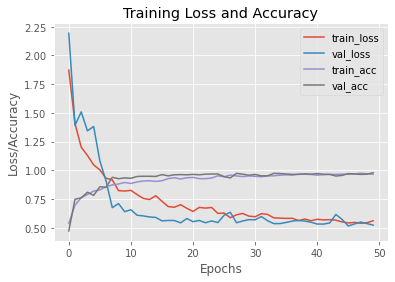

In [15]:
#@ PLOTTING TRAINING LOSS AND ACCURACY: 
N = epochs         
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show();